# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°2: Modelado PINN
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


### 1. Implementación básica de un esquema vanilla PINN para realizar el cómputo “directo” de las variables dependientes en estudio (en este caso, la presión 𝑝 y velocidades 𝑢 y 𝑣) 
_Implementar una rutina que incluya los pasos enumerados previamente. Tomar como referencia las implementaciones provistas por la cátedra (ver notebooks de Colab). Prestar especial atención al cómputo de las derivadas de la presión 𝑝 y velocidades 𝑢 y 𝑣 en función de las variables independientes, y a la construcción de los residuos correspondientes._

### 2. Resolver el sistema de ecuaciones del enunciado mediante PINN, sin emplear datos rotulados.
*Utilizar muestreos aleatorios tanto para el residuo de las PDE como para las condiciones de borde. Utilizar N<sub>pde</sub> = 10000 y N<sub>bc</sub> = 1000*

### Clase PINN Navier-stokes

In [2]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity

#### Configuración del dominio y condiciones de borde

In [3]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [4]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

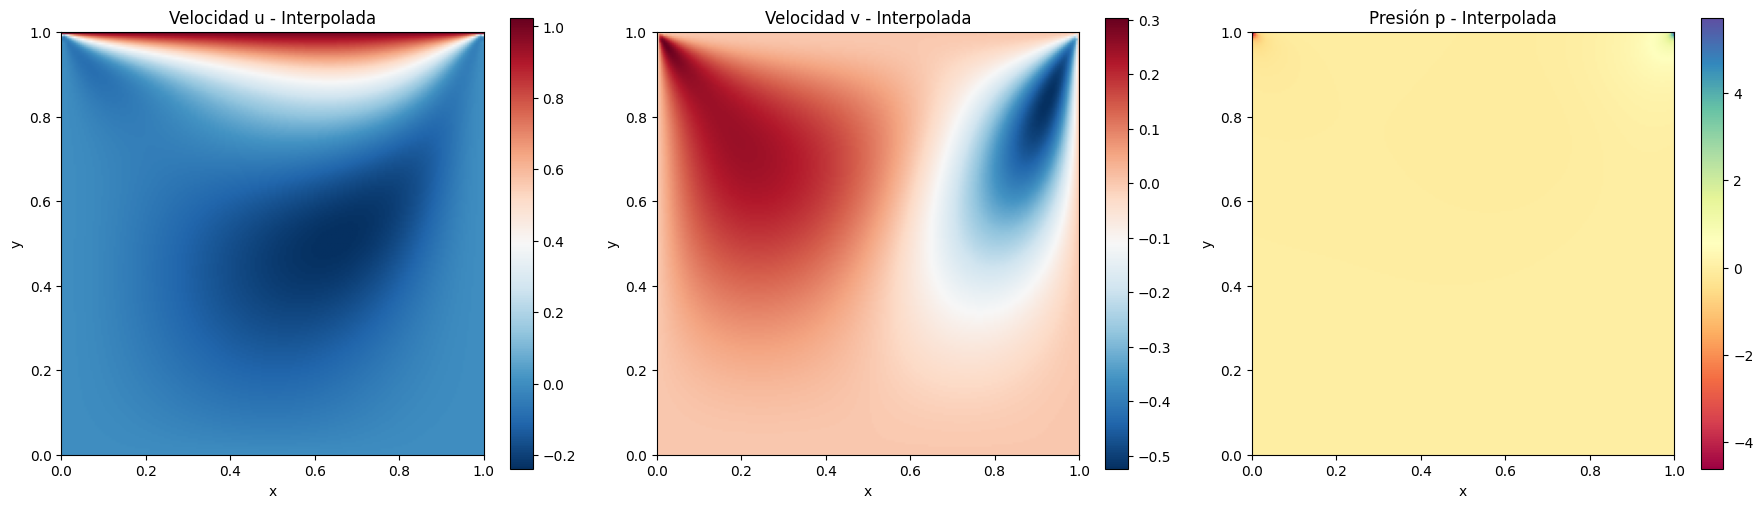

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

#### Generación de puntos de colocación 

In [6]:
def sample_training_points(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs:
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    # PDE points en el dominio [0,1] x [0,1]
    pde_points = torch.rand(N_pde, 2, device=device)

    # Puntos de borde
    N_each = N_bc // 4
    rand = torch.rand(N_each, device=device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

In [7]:
N_pde = 10000
N_bc = 1000

print(f"Generando puntos de colocación:")
pde_points, bottom, top, left, right, bc_points = sample_training_points(N_pde, N_bc, device)
print(f"  - N_pde = {N_pde}")
print(f"  - N_bc = {N_bc} (divididos en 4 bordes)")
print(f"Puntos generados exitosamente")

Generando puntos de colocación:
  - N_pde = 10000
  - N_bc = 1000 (divididos en 4 bordes)
Puntos generados exitosamente


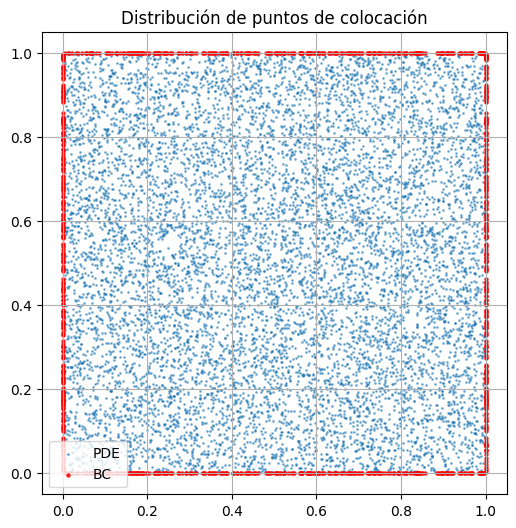

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(pde_points[:,0].cpu(), pde_points[:,1].cpu(), s=1, label='PDE', alpha=0.5)
plt.scatter(bc_points[:,0].cpu(), bc_points[:,1].cpu(), s=5, label='BC', color='red', alpha=0.8)
plt.legend()
plt.title("Distribución de puntos de colocación")
plt.grid(True)
plt.show()

#### Configuración del modelo

In [9]:
# Parámetros del modelo
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 64,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 5, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.Tanh()
}

In [10]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 5
  - Neuronas por capa: 64
  - Función de activación: Tanh()
  - Total de parámetros entrenables: 17027


### Entrenamiento

In [11]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

# Función para calcular pérdida de presión de referencia
def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)
    
    # Evaluar el modelo en el punto de referencia
    uvp_ref = model(reference_point)
    p_ref = uvp_ref[:, 2:3]  # Extraer presión
    
    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)
    
    return loss_fn(p_ref, target_pressure)

# Función de entrenamiento
def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, initial_weight_bc, final_weight_bc,
               weight_pressure_ref,  # agregado el peso para condición de referencia
               loss_fn=nn.MSELoss()):

    # Historial de pérdidas (agregamos nueva pérdida)
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []  # agregamos al historial la pérdida de referencia

    print("Iniciando entrenamiento ...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        progress = epoch / epochs
        current_weight_bc = initial_weight_bc * (1 - progress) + final_weight_bc * progress

        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE (los residuos deben ser cero)
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))

        loss_pde_total = loss_u + loss_v + loss_cont

        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)

        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)

        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Función de pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                     current_weight_bc * loss_bc_total +
                     weight_pressure_ref * loss_pressure_ref)  # agregado nuevo término

        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())  # agregado al historial

        # Log del progreso (incluida nueva pérdida)
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
                # Verificar presión en (0,0)
                ref_point = torch.tensor([[0.0, 0.0]], device=device)
                p_ref_value = model(ref_point)[0, 2].item()

            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                  f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        
    # Guardar modelo
    torch.save(model.state_dict(), f"models/pinn_trained_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

    # Retornar historial (MODIFICADO)
    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref  # NUEVO
    }

#### Gráficos de evolución de pérdidas

In [12]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"]  # NUEVO
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange']  # NUEVO color
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref']  # NUEVO título

    fig, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<18:42,  8.91it/s]

Epoch    0 | Total: 3.53e+04 | PDE: 4.89e+01 | BC: 5.42e+00 | P_ref: 3.26e-01 | p(0,0): 0.2373 | u_top: 0.360


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:07<02:14, 70.83it/s]

Epoch  500 | Total: 2.82e+02 | PDE: 3.55e-01 | BC: 5.14e-02 | P_ref: 9.82e-08 | p(0,0): -0.0003 | u_top: 0.936


Entrenando modelo PINN:  10%|█         | 1013/10000 [00:14<02:05, 71.78it/s]

Epoch 1000 | Total: 2.23e+02 | PDE: 2.55e-01 | BC: 4.30e-02 | P_ref: 8.06e-09 | p(0,0): -0.0001 | u_top: 0.947


Entrenando modelo PINN:  15%|█▌        | 1514/10000 [00:22<02:06, 67.32it/s]

Epoch 1500 | Total: 1.89e+02 | PDE: 2.23e-01 | BC: 3.80e-02 | P_ref: 6.55e-10 | p(0,0): -0.0000 | u_top: 0.953


Entrenando modelo PINN:  20%|██        | 2011/10000 [00:29<01:53, 70.58it/s]

Epoch 2000 | Total: 1.65e+02 | PDE: 2.06e-01 | BC: 3.43e-02 | P_ref: 9.52e-10 | p(0,0): -0.0000 | u_top: 0.957


Entrenando modelo PINN:  25%|██▌       | 2511/10000 [00:36<01:47, 69.73it/s]

Epoch 2500 | Total: 1.45e+02 | PDE: 1.95e-01 | BC: 3.14e-02 | P_ref: 5.44e-10 | p(0,0): -0.0000 | u_top: 0.961


Entrenando modelo PINN:  30%|███       | 3009/10000 [00:43<01:40, 69.49it/s]

Epoch 3000 | Total: 1.29e+02 | PDE: 1.86e-01 | BC: 2.91e-02 | P_ref: 2.54e-10 | p(0,0): -0.0000 | u_top: 0.963


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [00:50<01:31, 71.12it/s]

Epoch 3500 | Total: 1.16e+02 | PDE: 1.78e-01 | BC: 2.74e-02 | P_ref: 3.01e-11 | p(0,0): -0.0000 | u_top: 0.965


Entrenando modelo PINN:  40%|████      | 4015/10000 [00:57<01:25, 70.28it/s]

Epoch 4000 | Total: 1.05e+02 | PDE: 1.69e-01 | BC: 2.60e-02 | P_ref: 4.01e-13 | p(0,0): -0.0000 | u_top: 0.966


Entrenando modelo PINN:  45%|████▌     | 4513/10000 [01:04<01:15, 73.06it/s]

Epoch 4500 | Total: 9.58e+01 | PDE: 1.60e-01 | BC: 2.49e-02 | P_ref: 4.60e-13 | p(0,0): 0.0000 | u_top: 0.968


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:11<01:10, 70.38it/s]

Epoch 5000 | Total: 8.73e+01 | PDE: 1.51e-01 | BC: 2.41e-02 | P_ref: 6.42e-14 | p(0,0): -0.0000 | u_top: 0.969


Entrenando modelo PINN:  55%|█████▌    | 5512/10000 [01:18<01:01, 72.84it/s]

Epoch 5500 | Total: 7.96e+01 | PDE: 1.42e-01 | BC: 2.34e-02 | P_ref: 8.26e-13 | p(0,0): -0.0000 | u_top: 0.969


Entrenando modelo PINN:  60%|██████    | 6010/10000 [01:25<00:56, 70.65it/s]

Epoch 6000 | Total: 7.26e+01 | PDE: 1.33e-01 | BC: 2.28e-02 | P_ref: 3.46e-11 | p(0,0): -0.0000 | u_top: 0.970


Entrenando modelo PINN:  65%|██████▌   | 6512/10000 [01:32<00:51, 68.37it/s]

Epoch 6500 | Total: 6.61e+01 | PDE: 1.25e-01 | BC: 2.24e-02 | P_ref: 1.07e-11 | p(0,0): -0.0000 | u_top: 0.970


Entrenando modelo PINN:  70%|███████   | 7008/10000 [01:39<00:41, 72.13it/s]

Epoch 7000 | Total: 6.01e+01 | PDE: 1.16e-01 | BC: 2.20e-02 | P_ref: 5.30e-12 | p(0,0): -0.0000 | u_top: 0.970


Entrenando modelo PINN:  75%|███████▌  | 7512/10000 [01:46<00:34, 72.43it/s]

Epoch 7500 | Total: 5.44e+01 | PDE: 1.07e-01 | BC: 2.18e-02 | P_ref: 3.67e-12 | p(0,0): 0.0000 | u_top: 0.970


Entrenando modelo PINN:  80%|████████  | 8010/10000 [01:53<00:28, 69.78it/s]

Epoch 8000 | Total: 4.89e+01 | PDE: 9.85e-02 | BC: 2.17e-02 | P_ref: 1.28e-11 | p(0,0): 0.0000 | u_top: 0.970


Entrenando modelo PINN:  85%|████████▌ | 8508/10000 [02:00<00:21, 68.02it/s]

Epoch 8500 | Total: 4.37e+01 | PDE: 8.96e-02 | BC: 2.17e-02 | P_ref: 5.12e-13 | p(0,0): 0.0000 | u_top: 0.970


Entrenando modelo PINN:  90%|█████████ | 9008/10000 [02:08<00:14, 70.53it/s]

Epoch 9000 | Total: 3.86e+01 | PDE: 8.07e-02 | BC: 2.18e-02 | P_ref: 1.25e-12 | p(0,0): 0.0000 | u_top: 0.970


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [02:15<00:07, 69.55it/s]

Epoch 9500 | Total: 3.37e+01 | PDE: 7.16e-02 | BC: 2.21e-02 | P_ref: 4.17e-11 | p(0,0): 0.0000 | u_top: 0.969


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:21<00:00, 70.46it/s]


Epoch 9999 | Total: 2.88e+01 | PDE: 6.25e-02 | BC: 2.25e-02 | P_ref: 3.93e-11 | p(0,0): 0.0000 | u_top: 0.968

Tiempo total: 141.9 segundos


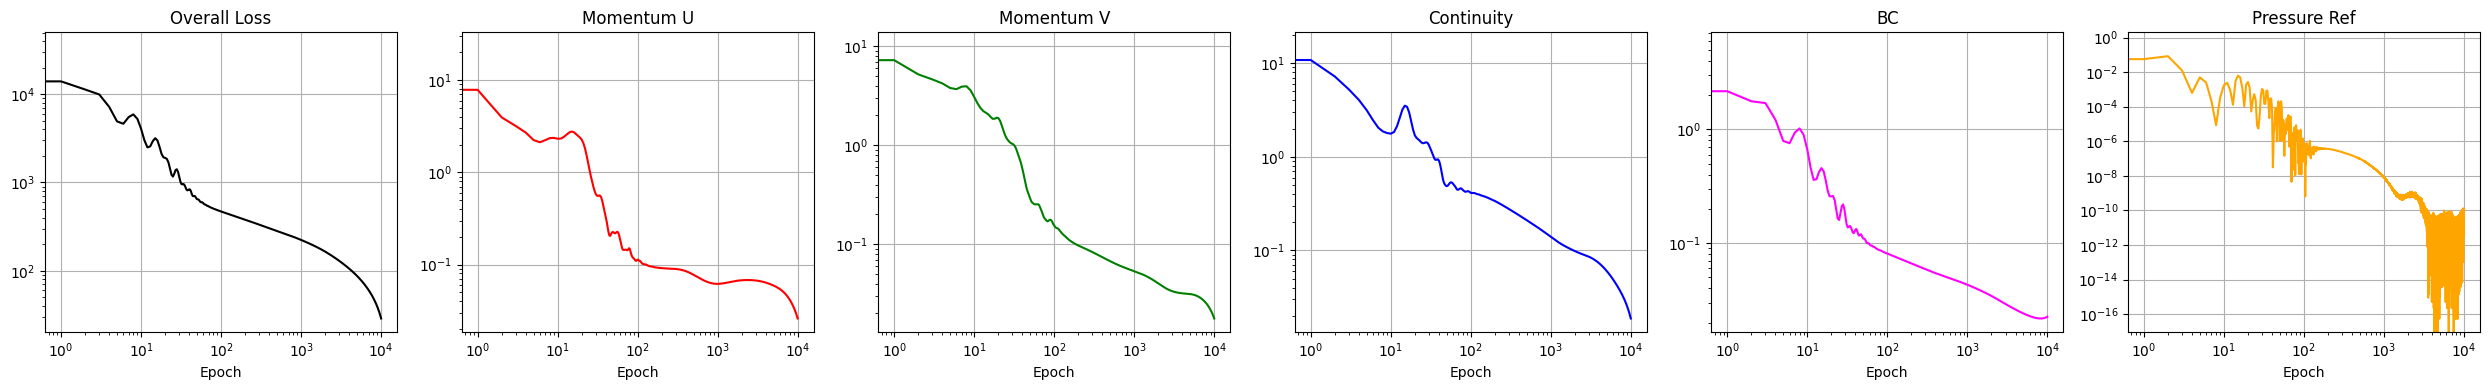

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)  # Decay gradual

# LOS PARÁMETROS CLAVE: El peso de presión de referencia debe ser alto
# ya que se evalúa en un solo punto vs miles de puntos PDE
losses = train_pinn(
                    model, pde_points, top, bottom, left, right,
                    epochs=10000,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    weight_pde=100.0,
                    initial_weight_bc=5000.0,
                    final_weight_bc=1000.0,
                    weight_pressure_ref=10000.0  # Este es nuevo: Peso alto para compensar un solo punto
                    )

plot_losses(losses)

In [14]:
# Verificación final de condiciones de borde
print("\n=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===")
with torch.no_grad():
    # Verificar condición lid-driven
    uvp_top_final = model(top)
    u_top_mean = uvp_top_final[:, 0].mean().item()
    u_top_std = uvp_top_final[:, 0].std().item()
    v_top_mean = uvp_top_final[:, 1].mean().item()
    
    # Verificar condiciones no-slip
    uvp_bottom_final = model(bottom)
    u_bottom_mean = uvp_bottom_final[:, 0].mean().item()
    v_bottom_mean = uvp_bottom_final[:, 1].mean().item()
    
    print(f"Borde superior (lid-driven):")
    print(f"  u: {u_top_mean:.6f} ± {u_top_std:.6f} (objetivo: 1.0)")
    print(f"  v: {v_top_mean:.6f} (objetivo: 0.0)")
    print(f"Borde inferior (no-slip):")
    print(f"  u: {u_bottom_mean:.6f} (objetivo: 0.0)")
    print(f"  v: {v_bottom_mean:.6f} (objetivo: 0.0)")
    
    # Status de convergencia de BC
    if abs(u_top_mean - 1.0) < 0.1:
        print("✓ Condición lid-driven SATISFECHA")
    else:
        print("⚠ Condición lid-driven NO satisfecha")
    
    if abs(u_bottom_mean) < 0.05 and abs(v_bottom_mean) < 0.05:
        print("✓ Condición no-slip SATISFECHA")  
    else:
        print("⚠ Condición no-slip NO satisfecha")



=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===
Borde superior (lid-driven):
  u: 0.968476 ± 0.087312 (objetivo: 1.0)
  v: 0.015598 (objetivo: 0.0)
Borde inferior (no-slip):
  u: -0.000875 (objetivo: 0.0)
  v: 0.001486 (objetivo: 0.0)
✓ Condición lid-driven SATISFECHA
✓ Condición no-slip SATISFECHA


In [15]:
# Verificación específica de la condición de referencia
print("\n=== VERIFICACIÓN DE CONDICIÓN DE REFERENCIA ===")
with torch.no_grad():
    ref_point = torch.tensor([[0.0, 0.0]], device=device)
    uvp_ref_final = model(ref_point)
    p_ref_final = uvp_ref_final[0, 2].item()
    
    print(f"Presión en (0,0): {p_ref_final:.6f} (objetivo: 0.0)")
    
    if abs(p_ref_final) < 0.01:
        print("✓ Condición de referencia SATISFECHA")
    else:
        print("⚠ Condición de referencia NO satisfecha - aumentar weight_pressure_ref")


=== VERIFICACIÓN DE CONDICIÓN DE REFERENCIA ===
Presión en (0,0): 0.000006 (objetivo: 0.0)
✓ Condición de referencia SATISFECHA


### 3. Calcular la norma-2 del error entre los valores de presión 𝑝⋅y velocidades (𝑢⋅, 𝑣⋅) que predice el modelo y sus correspondientes valores ground-truth. 
_Para ello, computar los campos de presión y velocidad en la misma grilla de puntos que la empleada en la solución de referencia._

In [16]:
print("Realizando predicción en la malla regular...")

# Predicción del modelo en los puntos de evaluación (X_eval ya tiene 201x201 puntos aplanados)
with torch.no_grad():
    uvp_pred = model(X_eval)

# Separar componentes y reordenar en grillas 201x201
u_pred = uvp_pred[:, 0].cpu().numpy().reshape(201, 201)
v_pred = uvp_pred[:, 1].cpu().numpy().reshape(201, 201)
p_pred = uvp_pred[:, 2].cpu().numpy().reshape(201, 201)

print("Predicción completada")

# Calcular errores absolutos punto a punto
error_u = np.abs(u_pred - U_grid)
error_v = np.abs(v_pred - V_grid)
error_p = np.abs(p_pred - P_grid)

# Calcular normas-2 de los errores
norm2_error_u = np.linalg.norm(error_u)
norm2_error_v = np.linalg.norm(error_v)
norm2_error_p = np.linalg.norm(error_p)

# Calcular normas-2 de las soluciones de referencia para error relativo
norm2_ref_u = np.linalg.norm(U_grid)
norm2_ref_v = np.linalg.norm(V_grid)
norm2_ref_p = np.linalg.norm(P_grid)

# Errores relativos
rel_error_u = norm2_error_u / norm2_ref_u * 100
rel_error_v = norm2_error_v / norm2_ref_v * 100
rel_error_p = norm2_error_p / norm2_ref_p * 100

# Mostrar resultados
print("=== ANÁLISIS DE ERRORES (NORMA-2) ===")
print(f"Norma-2 del error absoluto:")
print(f"  - Velocidad u: {norm2_error_u:.6e}")
print(f"  - Velocidad v: {norm2_error_v:.6e}")
print(f"  - Presión p:   {norm2_error_p:.6e}")
print(f"\nError relativo (%):")
print(f"  - Velocidad u: {rel_error_u:.2f}%")
print(f"  - Velocidad v: {rel_error_v:.2f}%")
print(f"  - Presión p:   {rel_error_p:.2f}%")

Realizando predicción en la malla regular...
Predicción completada
=== ANÁLISIS DE ERRORES (NORMA-2) ===
Norma-2 del error absoluto:
  - Velocidad u: 1.489161e+01
  - Velocidad v: 1.757292e+01
  - Presión p:   1.431866e+01

Error relativo (%):
  - Velocidad u: 33.86%
  - Velocidad v: 58.99%
  - Presión p:   69.66%


### 4. Graficar el error absoluto entre los valores de presión 𝑝⋅ y velocidades (𝑢⋅, 𝑣⋅) que predice el modelo y sus correspondientes valores medidos (utilizando la misma grilla que en el punto anterior).

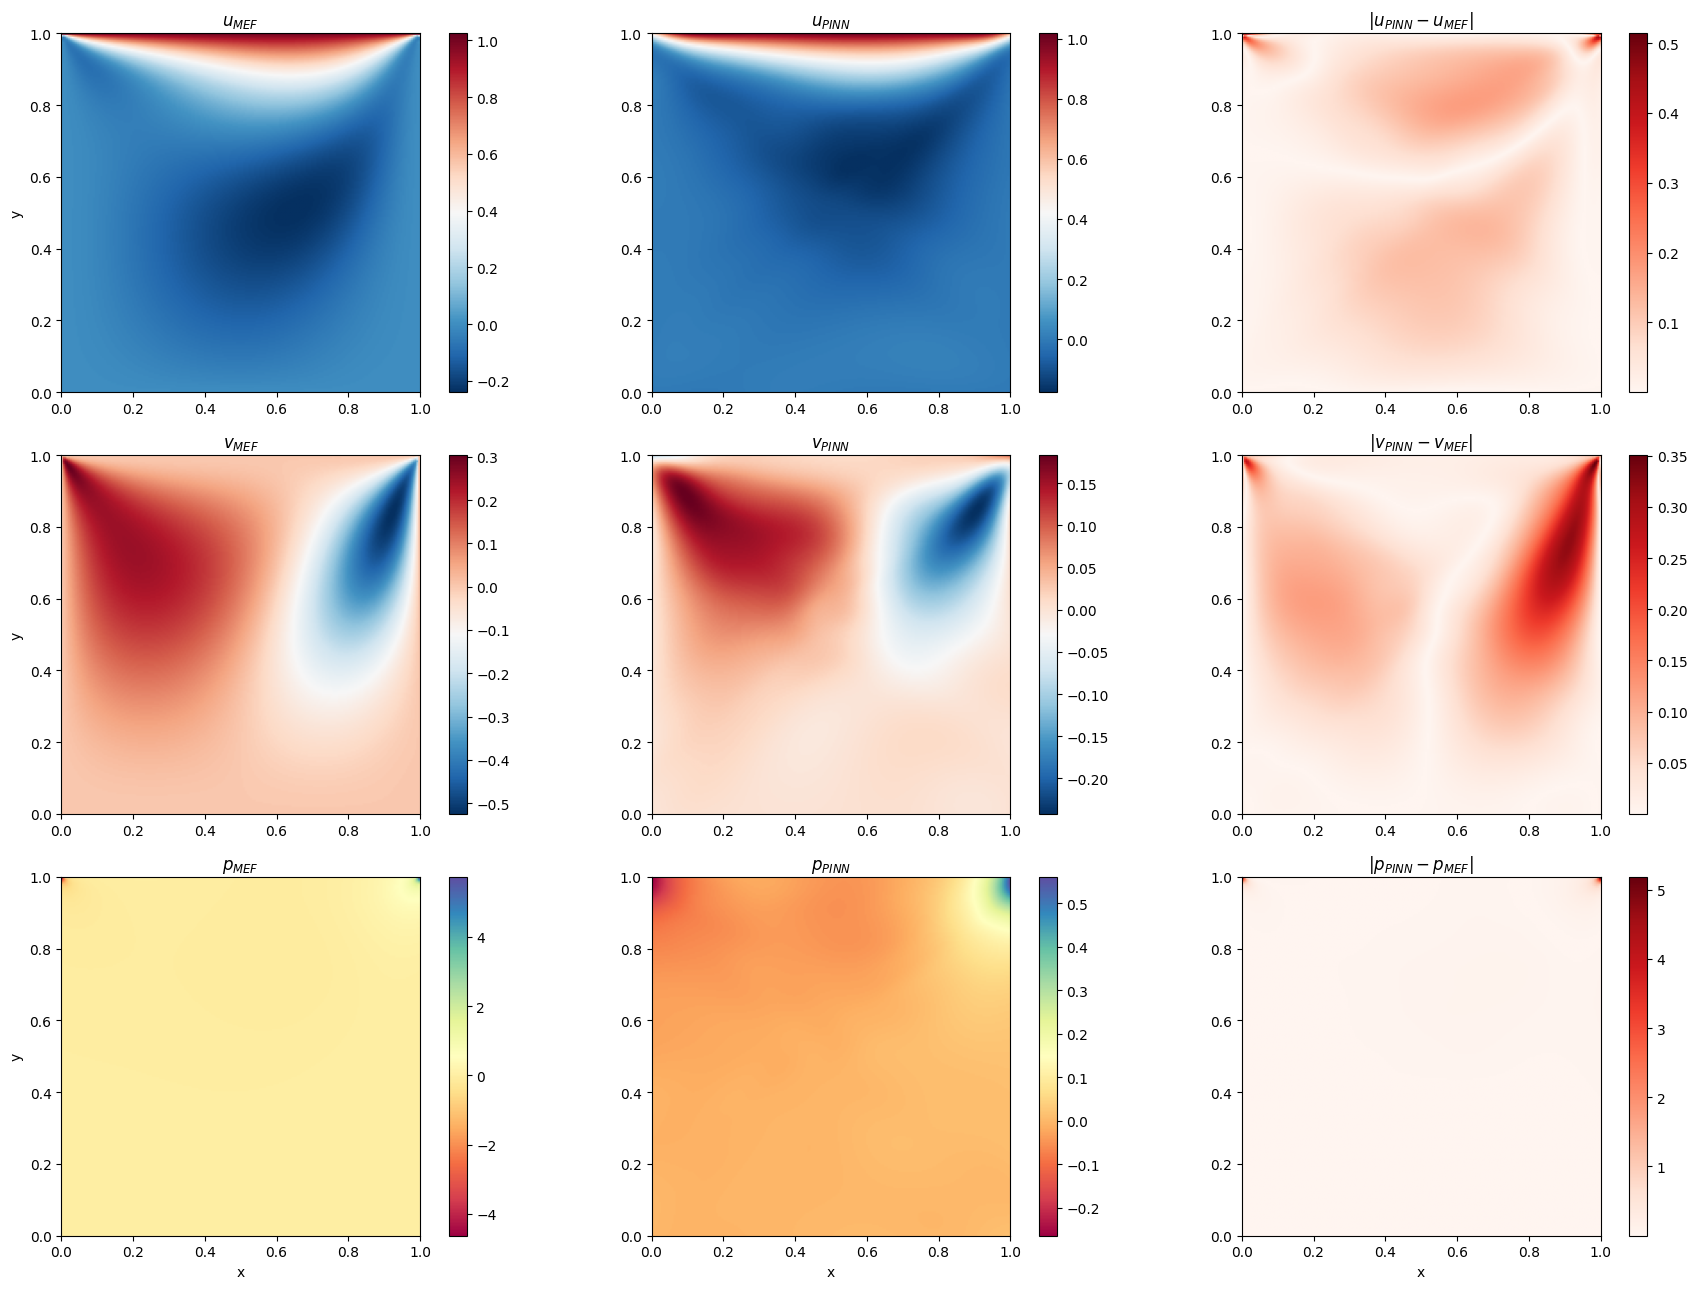

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(18, 13))

# --- Velocidad u ---
# u_ref (MEF)
im0 = axs[0, 0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[0, 0].set_title(r"$u_{MEF}$")
axs[0, 0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0, 0])

# u_pred
im1 = axs[0, 1].imshow(u_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[0, 1].set_title(r"$u_{PINN}$")
plt.colorbar(im1, ax=axs[0, 1])

# error_u
im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
plt.colorbar(im2, ax=axs[0, 2])

# --- Velocidad v ---
# v_ref
im3 = axs[1, 0].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[1, 0].set_title(r"$v_{MEF}$")
axs[1, 0].set_ylabel("y")
plt.colorbar(im3, ax=axs[1, 0])

# v_pred
im4 = axs[1, 1].imshow(v_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='RdBu_r', aspect='equal')
axs[1, 1].set_title(r"$v_{PINN}$")
plt.colorbar(im4, ax=axs[1, 1])

# error_v
im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
plt.colorbar(im5, ax=axs[1, 2])

# --- Presion p ---
# p_ref
im6 = axs[2, 0].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Spectral', aspect='equal')
axs[2, 0].set_title(r"$p_{MEF}$")
axs[2, 0].set_ylabel("y")
axs[2, 0].set_xlabel("x")
plt.colorbar(im6, ax=axs[2, 0])

# p_pred
im7 = axs[2, 1].imshow(p_pred, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Spectral', aspect='equal')
axs[2, 1].set_title(r"$p_{PINN}$")
axs[2, 1].set_xlabel("x")
plt.colorbar(im7, ax=axs[2, 1])

# error_p
im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='Reds', aspect='equal')
axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
axs[2, 2].set_xlabel("x")
plt.colorbar(im8, ax=axs[2, 2])

plt.tight_layout()
plt.savefig('./graficas/comparacion_u_v_p_total.png')
plt.show()


#### Análisis de perfiles en líneas características

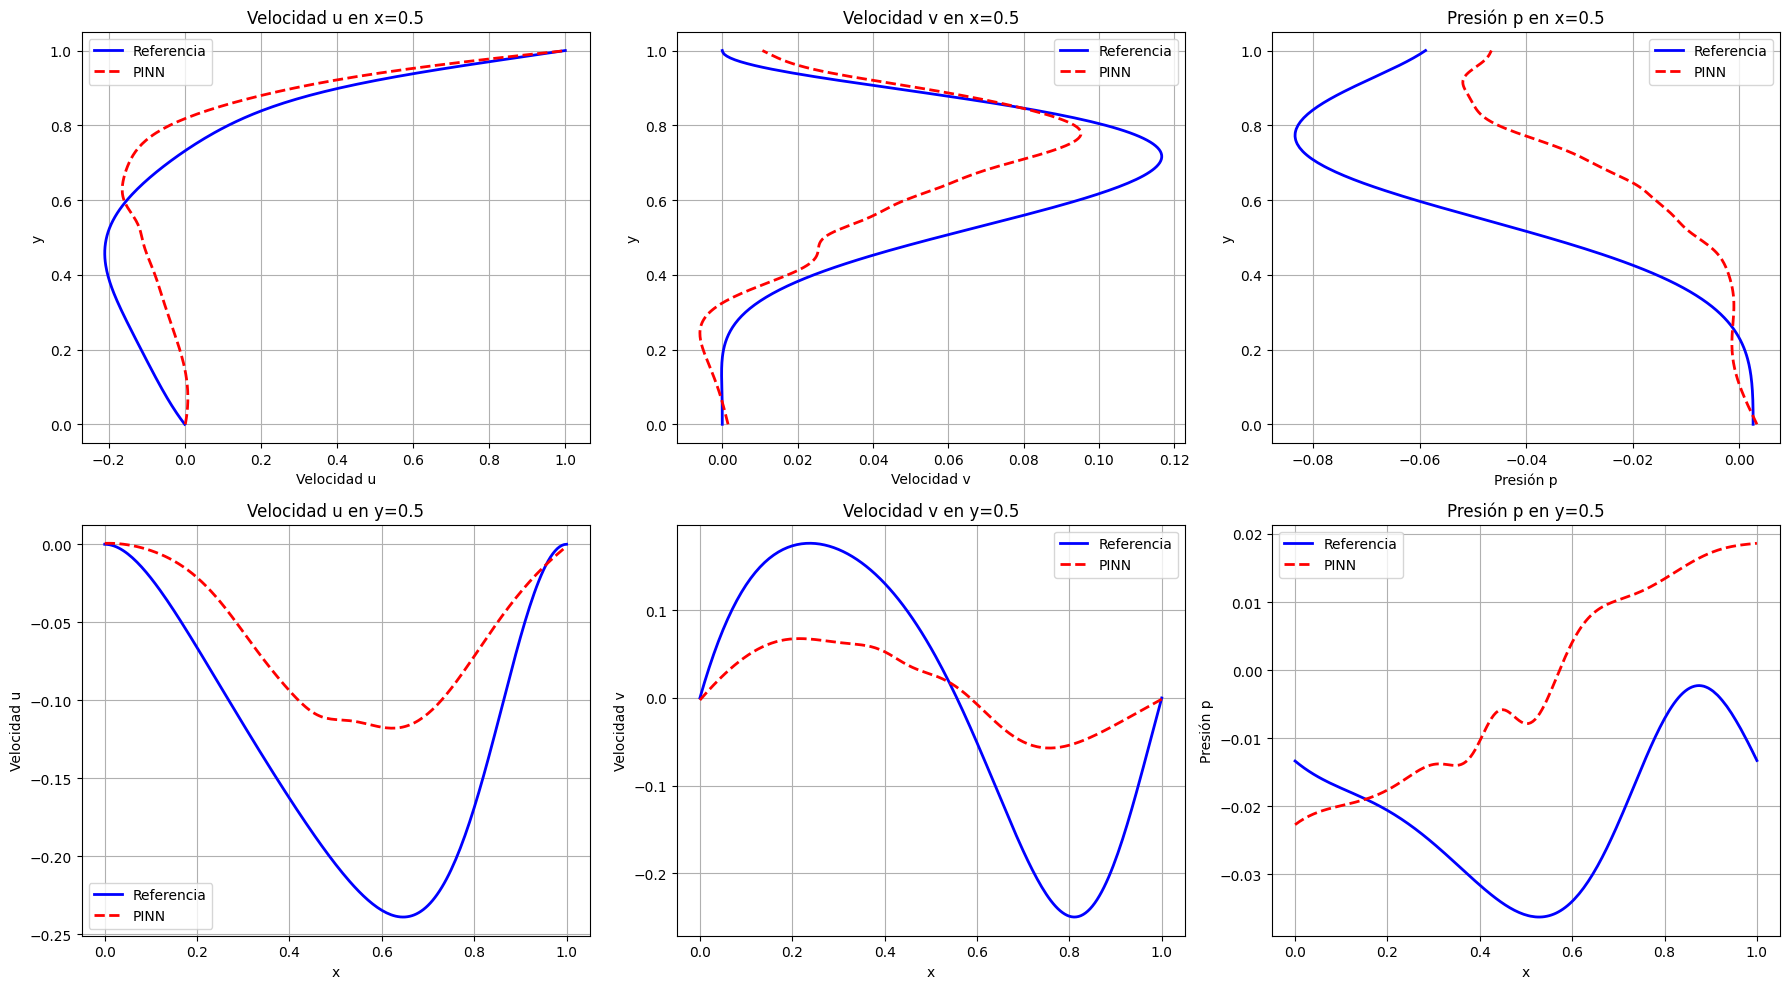

In [18]:
# Índices centrales de la malla
x_center_idx = 100  # x=0.5 en grilla de 201 puntos
y_center_idx = 100  # y=0.5 en grilla de 201 puntos

# Ejes
x_line = X_grid[0, :]  # valores de x a lo largo de una fila
y_line = Y_grid[:, 0]  # valores de y a lo largo de una columna

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# --- FILA SUPERIOR: cortes verticales en x=0.5 (vs y) ---
axs[0, 0].plot(U_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 0].plot(u_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 0].set_xlabel('Velocidad u')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Velocidad u en x=0.5')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(V_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 1].plot(v_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 1].set_xlabel('Velocidad v')
axs[0, 1].set_ylabel('y')
axs[0, 1].set_title('Velocidad v en x=0.5')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[0, 2].plot(P_grid[:, x_center_idx], y_line, 'b-', linewidth=2, label='Referencia')
axs[0, 2].plot(p_pred[:, x_center_idx], y_line, 'r--', linewidth=2, label='PINN')
axs[0, 2].set_xlabel('Presión p')
axs[0, 2].set_ylabel('y')
axs[0, 2].set_title('Presión p en x=0.5')
axs[0, 2].legend()
axs[0, 2].grid(True)

# --- FILA INFERIOR: cortes horizontales en y=0.5 (vs x) ---
axs[1, 0].plot(x_line, U_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 0].plot(x_line, u_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Velocidad u')
axs[1, 0].set_title('Velocidad u en y=0.5')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(x_line, V_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 1].plot(x_line, v_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('Velocidad v')
axs[1, 1].set_title('Velocidad v en y=0.5')
axs[1, 1].legend()
axs[1, 1].grid(True)

axs[1, 2].plot(x_line, P_grid[y_center_idx, :], 'b-', linewidth=2, label='Referencia')
axs[1, 2].plot(x_line, p_pred[y_center_idx, :], 'r--', linewidth=2, label='PINN')
axs[1, 2].set_xlabel('x')
axs[1, 2].set_ylabel('Presión p')
axs[1, 2].set_title('Presión p en y=0.5')
axs[1, 2].legend()
axs[1, 2].grid(True)

plt.tight_layout()
plt.savefig('./graficas/perfiles_lineas_caracteristicas.png')
plt.show()

### 5. Evaluación y análisis del modelo desarrollado

_En base al grado de convergencia obtenido durante el entrenamiento y los gráficos de error ¿Considera que el modelo desarrollado es suficientemente “bueno” para predecir los campos de presión y velocidad? ¿Qué fallas observa? ¿Qué aspectos positivos destaca? ¿Considera que los hiperparámetros que definió son adecuados? ¿Puede mejorarse el desempeño del modelo? En caso afirmativo ¿Qué acciones de mejoras se podrían implementar?_

**¿Considera que el modelo desarrollado es suficientemente “bueno” para predecir los campos de presión y velocidad?**

El modelo logra capturar correctamente la forma general del flujo, en especial para los campos de velocidad `u` y `v`. Se observan estructuras coherentes y un comportamiento global esperable. Sin embargo, los perfiles en los cortes verticales y horizontales muestran que, si bien la tendencia de las curvas se respeta, las magnitudes predichas no coinciden con las de referencia, especialmente en la presión, que presenta un desplazamiento sistemático. A pesar de esto, el modelo cumple correctamente con las condiciones de borde. Por lo tanto, aunque el modelo captura adecuadamente las formas generales, su precisión cuantitativa aún necesita mejoras.

**¿Qué fallas observa?**
- La presión tiene una forma similar a la esperada, pero con un sesgo claro. Por ejemplo, en los cortes centrales, se mantiene en valores negativos cuando debería estar cercana a cero.
- Las componentes `u` y `v` tambien muestran errores en la magnitud, aunque siguen razonablemente la forma esperada.
- Aunque la pérdida global disminuye, hay un estancamiento leve en las últimas épocas.
- El error absoluto es mayor en ciertas zonas del dominio, lo que podría relacionarse con la complejidad local del flujo. Podría explorarse un muestreo más denso o adaptativo en esas regiones.

**¿Qué aspectos positivos destaca?**
- El modelo captura bastante bien la estructura del campo de `u`, que es la variable dominante del flujo.
- Las condiciones de borde lid-driven y no-slip se cumplen con precisión tanto numéricamente como visualmente.
- La conservación de masa se cumple de forma razonable, aunque el residuo podría ser más bajo.
- La pérdida total disminuyó de forma sostenida durante todo el entrenamiento.

**¿Considera que los hiperparámetros que definió son adecuados?**

La arquitectura utilizada (5 capas, 64 neuronas por capa) resultó suficiente para capturar la dinámica general del flujo, pero insuficiente para ajustar correctamente las magnitudes, en particular de la presión. El esquema de entrenamiento fue estable y efectivo, pero podría beneficiarse de un ajuste fino adicional.

**¿Puede mejorarse el desempeño del modelo? En caso afirmativo ¿Qué acciones de mejoras se podrían implementar?**
- Aumentar la cantidad de capas y neuronas para darle más capacidad de representación a la red.
- Utilizar un optimizador como L-BFGS en la etapa final para mejorar la convergencia fina.
- Ajustar los pesos relativos de los términos de la función de pérdida, especialmente para priorizar la presión.
- Emplear muestreo adaptativo en regiones de alto gradiente o cerca de las paredes.

In [19]:
print("=== EVALUACIÓN DEL MODELO PINN DESARROLLADO ===\n")

# 1. CONVERGENCIA
print("1. GRADO DE CONVERGENCIA DURANTE EL ENTRENAMIENTO:")
loss_train = losses['total']
initial_loss = loss_train[0]
final_loss = loss_train[-1]
reduction_factor = initial_loss / final_loss
print(f"   - Pérdida inicial: {initial_loss:.6e}")
print(f"   - Pérdida final: {final_loss:.6e}")
print(f"   - Factor de reducción: {reduction_factor:.2f}x")

# Coeficiente de variación en últimas 100 épocas
if len(loss_train) >= 100:
    last_std = np.std(loss_train[-100:])
    last_mean = np.mean(loss_train[-100:])
    cv = last_std / last_mean * 100
    print(f"   - CV últimas 100 épocas: {cv:.2f}%")
    convergence_status = "✓ BUENA" if cv < 5 else "⚠ MODERADA"
    print(f"   - Estado de convergencia: {convergence_status}")
else:
    print("   - No hay suficientes épocas para evaluar CV")

# 2. ERRORES
print("\n2. PRECISIÓN DE PREDICCIÓN DE CAMPOS:")
print(f"   - Error relativo velocidad u: {rel_error_u:.2f}%")
print(f"   - Error relativo velocidad v: {rel_error_v:.2f}%")
print(f"   - Error relativo presión p:   {rel_error_p:.2f}%")

if rel_error_u < 5 and rel_error_v < 5 and rel_error_p < 10:
    precision_level = "EXCELENTE"
elif rel_error_u < 10 and rel_error_v < 10 and rel_error_p < 20:
    precision_level = "BUENA"
elif rel_error_u < 20 and rel_error_v < 20 and rel_error_p < 30:
    precision_level = "ACEPTABLE"
else:
    precision_level = "NECESITA MEJORAS"
print(f"   - Clasificación general: {precision_level}")

# 3. FALLAS OBSERVADAS
print("\n3. FALLAS OBSERVADAS:")

# Conservación de masa (residuo de continuidad)
X_test = torch.rand(1000, 2, device=device, requires_grad=True)
uvp_test = model(X_test)
_, _, res_cont = model.navierstokesResidue(X_test, uvp_test)
avg_cont_res = torch.mean(torch.abs(res_cont)).item()
if avg_cont_res > 1e-2:
    print(f"   ⚠ Violación de conservación de masa: residuo promedio = {avg_cont_res:.2e}")

# Condiciones de borde
u_top_center = u_pred[-1, 100]
u_bottom_center = u_pred[0, 100]
v_left_center = v_pred[100, 0]
if abs(u_top_center - 1.0) > 0.1:
    print(f"   ⚠ Condición de borde superior mal satisfecha (u={u_top_center:.3f}, esperado=1.0)")
if abs(u_bottom_center) > 0.05:
    print(f"   ⚠ No-slip inferior mal satisfecho (u={u_bottom_center:.3f})")
if abs(v_left_center) > 0.05:
    print(f"   ⚠ No-slip lateral mal satisfecho (v={v_left_center:.3f})")

# 4. ASPECTOS POSITIVOS
print("\n4. ASPECTOS POSITIVOS DESTACADOS:")
if reduction_factor > 100:
    print("   ✓ Excelente reducción de pérdida durante entrenamiento")
if rel_error_u < 10 and rel_error_v < 10:
    print("   ✓ Buena captura de velocidades")
if avg_cont_res < 1e-2:
    print(f"   ✓ Buena conservación de masa (residuo: {avg_cont_res:.2e})")
if abs(u_top_center - 1.0) < 0.05:
    print("   ✓ Correcta implementación de condición lid-driven")
if cv < 5:
    print("   ✓ Entrenamiento estable y bien convergido")

# 5. HIPERPARÁMETROS
print("\n5. CONSIDERACIÓN SOBRE HIPERPARÁMETROS:")
print(f"   - Learning rate final: {optimizer.param_groups[0]['lr']:.2e}")
print(f"   - Arquitectura: {model_parameters['NumberOfHiddenLayers']} capas, {model_parameters['NumberOfNeurons']} neuronas")
print(f"   - Épocas de entrenamiento: {len(loss_train)}")

if final_loss > 1e-4 or rel_error_p > 20:
    print("   → Sugerencias de ajuste:")
    print("     • Reducir LR o usar L-BFGS para fine-tuning")
    print("     • Aumentar peso del término PDE (especialmente para presión)")
    print("     • Incrementar complejidad de red")

# 6. ACCIONES DE MEJORA
print("\n6. ACCIONES DE MEJORA RECOMENDADAS:")
print("   • Incrementar número de épocas (ej: 10,000)")
print("   • Usar L-BFGS al final para fine-tuning")
print("   • Mayor muestreo en bordes o regiones críticas")
print("   • Aumentar número de capas/neuronas si se estanca")

# 7. CONCLUSIÓN
print("\n=== CONCLUSIÓN GENERAL ===")
if precision_level in ["EXCELENTE", "BUENA"]:
    print("El modelo PINN es adecuado para predecir los campos de presión y velocidad.")
else:
    print("El modelo es prometedor, pero requiere ajustes para alcanzar mayor precisión.")

print(f"\nEl modelo puede considerarse '{precision_level}' para este problema.")


=== EVALUACIÓN DEL MODELO PINN DESARROLLADO ===

1. GRADO DE CONVERGENCIA DURANTE EL ENTRENAMIENTO:
   - Pérdida inicial: 3.526738e+04
   - Pérdida final: 2.875660e+01
   - Factor de reducción: 1226.41x
   - CV últimas 100 épocas: 0.97%
   - Estado de convergencia: ✓ BUENA

2. PRECISIÓN DE PREDICCIÓN DE CAMPOS:
   - Error relativo velocidad u: 33.86%
   - Error relativo velocidad v: 58.99%
   - Error relativo presión p:   69.66%
   - Clasificación general: NECESITA MEJORAS

3. FALLAS OBSERVADAS:
   ⚠ Violación de conservación de masa: residuo promedio = 6.51e-02

4. ASPECTOS POSITIVOS DESTACADOS:
   ✓ Excelente reducción de pérdida durante entrenamiento
   ✓ Correcta implementación de condición lid-driven
   ✓ Entrenamiento estable y bien convergido

5. CONSIDERACIÓN SOBRE HIPERPARÁMETROS:
   - Learning rate final: 6.73e-06
   - Arquitectura: 5 capas, 64 neuronas
   - Épocas de entrenamiento: 10000
   → Sugerencias de ajuste:
     • Reducir LR o usar L-BFGS para fine-tuning
     • Aume